In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data preparation

In [2]:
car_price_dataset_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
columns = ['Make', 'Model', 'Year', 'Engine HP',
           'Engine Cylinders', 'Transmission Type',
           'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = pd.read_csv(car_price_dataset_url, usecols=columns)
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.select_dtypes('object').columns)
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.lower().str.replace(' ', '_'))
df.engine_hp.fillna(0, inplace=True)
df.engine_cylinders.fillna(0, inplace=True)
df['above_average'] = (df.msrp > df.msrp.mean()).astype('int64')
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
 10  above_average      11914 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1024.0+ KB


In [4]:
X = df.drop(['msrp', 'above_average'], axis=1)
y = df.above_average

#### Split data into training (60%), validation (20%) and testing (20%)

In [5]:
from sklearn.model_selection import train_test_split
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [6]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. For each numerical variable, use it as score and compute AUC with the `above_average` variable. Use the training dataset for that. If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. `-df_train['engine_hp']`). AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive. Which numerical variable (among the following 4) has the highest AUC?

* `engine_hp`
* `engine_cylinders`
* `highway_mpg`
* `city_mpg`

In [7]:
from sklearn.metrics import roc_auc_score
numerical_columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
auc_scores = []
for col in numerical_columns:
    if col in ['highway_mpg', 'city_mpg']:
        X_col = -X_train[col].values.reshape(-1, 1)
    else:
        X_col = X_train[col].values.reshape(-1, 1)
    auc_scores.append(roc_auc_score(y_train.ravel(), X_col).round(4))
auc_scores_df = pd.DataFrame(auc_scores, index=numerical_columns, columns=['AUC'])
auc_scores_df.sort_values(ascending=False, by='AUC', inplace=True)
auc_scores_df

,AUC
engine_hp,0.9171
engine_cylinders,0.7661
year,0.6876
city_mpg,0.6734
highway_mpg,0.6331


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`. What's the AUC of this model on the validation dataset? (round to 3 digits).

* 0.678
* 0.779
* 0.878
* 0.979

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [9]:
def data_transformation(X_tr, X_val):
    X_tr_dicts = X_tr.to_dict(orient='records')
    X_val_dicts = X_val.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_onehot_tr = dv.fit_transform(X_tr_dicts)
    X_onehot_val = dv.transform(X_val_dicts)
    return X_onehot_tr, X_onehot_val

In [10]:
X_onehot_train, X_onehot_val = data_transformation(X_train, X_val)

In [11]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_onehot_train, y_train)
y_pred = lr.predict_proba(X_onehot_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.976

### Question 3: Precision and Recall

Now let's compute precision and recall for our model. Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall and plot them. At which threshold do the precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [51]:
thresholds = np.linspace(0.0, 0.99, 100)
scores = []
for t in thresholds:
    tp = ((y_pred >= t) == 1) & (y_val == 1)
    fp = ((y_pred >= t) == 1) & (y_val == 0)
    tn = ((y_pred >= t) == 0) & (y_val == 0)
    fn = ((y_pred >= t) == 0) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    scores.append((t, p, r, p-r))

p_r_df = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'p_minus_r'])

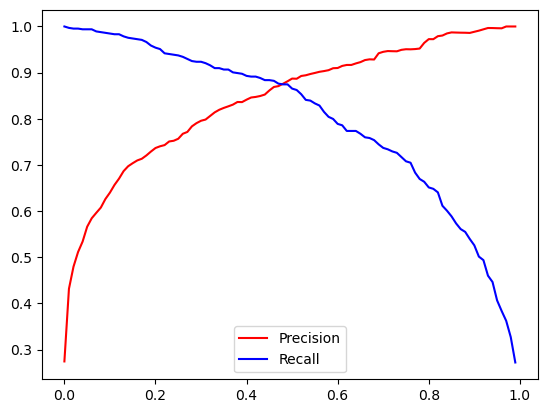

In [52]:
fig, ax = plt.subplots()
ax.plot(thresholds, p_r_df.precision, color='red', label='Precision')
ax.plot(thresholds, p_r_df.recall, color='blue', label='Recall')
ax.legend();

In [54]:
p_r_df['minus_abs_p_minus_r'] = p_r_df.p_minus_r.apply(lambda x: -abs(x))
p_r_df[['threshold', 'minus_abs_p_minus_r']].nlargest(5, 'minus_abs_p_minus_r')

,threshold,minus_abs_p_minus_r
48,0.48,-0.001339
47,0.47,-0.005326
49,0.49,-0.006738
46,0.46,-0.013287
50,0.50,-0.021704


### Question 4: F1 score

Precision and recall are conflicting &ndash; when one grows, the other goes down. That's why they are often combined into the $F_1$ score &ndash; a metrics that takes into account both. This is the formula for computing $F_1$:

$$F_1 = \frac{2}{\frac{1}{P} + \frac{1}{R}} = \frac{2 P R}{P + R},$$

where $P$ is precision and $R$ is recall. Let's compute $F_1$ for all thresholds from 0.0 to 1.0 with increment 0.01. At which threshold $F_1$ is maximal?

* 0.12
* 0.32
* 0.52
* 0.72

In [29]:
thresholds = np.linspace(0.0, 0.99, 100)
f1_scores = []
for t in thresholds:
    tp = ((y_pred >= t) == 1) & (y_val == 1)
    fp = ((y_pred >= t) == 1) & (y_val == 0)
    tn = ((y_pred >= t) == 0) & (y_val == 0)
    fn = ((y_pred >= t) == 0) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    f1 = 2*p*r/(p+r)
    f1_scores.append((t, f1))

f1_df = pd.DataFrame(f1_scores, columns=['threshold', 'f-score'])

In [31]:
f1_df.nlargest(5, 'f-score')

,threshold,f-score
49,0.49,0.877974
50,0.50,0.876161
46,0.46,0.875569
48,0.48,0.875287
51,0.51,0.874419
